In [2]:
# Datasets were download from Kaggle (https://www.kaggle.com/datasets/dem0nking/world-checklist-of-vascular-plants-wcvp-dataset/data)
import pandas as pd
distribution_dataset = pd.read_csv("wcvp_distribution.csv")
names_dataset = pd.read_csv("wcvp_names.csv", low_memory=False)
plants = pd.merge(distribution_dataset, names_dataset, on='plant_name_id', how='left')


In [3]:
# Upon previous careful exploratory data analysis performed on the datasets, relevant columns have been selected for the the purpose of the model development
plants = plants[['continent', 'region', 'area', 'introduced', 'extinct', 'taxon_rank', 'taxon_status', 'family', 'genus', 'species', 'taxon_name', 'lifeform_description', 'climate_description']]
print(plants.isnull().sum())

continent                    0
region                     100
area                       711
introduced                   0
extinct                      0
taxon_rank              117844
taxon_status            117844
family                  117844
genus                   117844
species                 198198
taxon_name              117844
lifeform_description    242219
climate_description     205100
dtype: int64


In [4]:
# Data Cleaning
columns_to_impute = ['taxon_rank', 'taxon_status', 'family', 'genus', 'species', 'taxon_name', 'lifeform_description', 'climate_description']
plants[columns_to_impute] = plants[columns_to_impute].fillna('Unknown')
columns_to_check = ['region', 'area']
plants = plants.dropna(subset=columns_to_check)
print(plants.isnull().sum())
print(plants.shape)

continent               0
region                  0
area                    0
introduced              0
extinct                 0
taxon_rank              0
taxon_status            0
family                  0
genus                   0
species                 0
taxon_name              0
lifeform_description    0
climate_description     0
dtype: int64
(1047864, 13)


In [5]:
# Feature Engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Encoding Categorical columns
categorical_columns = ['continent', 'region', 'area', 'taxon_rank', 'taxon_status', 'family', 'genus', 'species', 'taxon_name', 'lifeform_description', 'climate_description']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    plants[col] = le.fit_transform(plants[col])
    label_encoders[col] = le

In [6]:
# Splitting the data into training (80%), validation (10%) and testing (10%) sets
train_plants, val_test_plants = train_test_split(plants, test_size=0.2, random_state=42)
val_plants, test_plants = train_test_split(val_test_plants, test_size=0.5, random_state=42, shuffle=True)

In [7]:
X_train = train_plants.drop(columns=['introduced'])
y_train = train_plants['introduced']

X_val = val_plants.drop(columns=['introduced'])
y_val = val_plants['introduced']

X_test = test_plants.drop(columns=['introduced'])
y_test = test_plants['introduced']


In [8]:
# Initializing the Random Forest Classifier
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rfc_model.fit(X_train, y_train)

y_val_pred = rfc_model.predict(X_val)

print("Validation Set Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))


Validation Set Results:
Accuracy: 0.9606626839463287
Confusion Matrix:
 [[92838   547]
 [ 3575  7826]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     93385
           1       0.93      0.69      0.79     11401

    accuracy                           0.96    104786
   macro avg       0.95      0.84      0.88    104786
weighted avg       0.96      0.96      0.96    104786



In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

# Sample a subset of the data
X_train_subset, y_train_subset = resample(X_train, y_train, n_samples=int(0.01 * len(X_train)), random_state=42)

# hyperparameter space to search
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

rfc_model_1 = RandomForestClassifier(random_state=42)

# randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rfc_model_1, param_distributions=param_grid, n_iter=5, cv=5, scoring='f1_macro')
random_search.fit(X_train_subset, y_train_subset)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'class_weight': 'balanced'}
Best Score: 0.6306382864577311


In [10]:
best_rfc_model = random_search.best_estimator_
best_rfc_model.fit(X_train, y_train)

y_val_pred = best_rfc_model.predict(X_val)

print("Validation Set Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Set Results:
Accuracy: 0.7403565361784972
Confusion Matrix:
 [[68253 25132]
 [ 2075  9326]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.83     93385
           1       0.27      0.82      0.41     11401

    accuracy                           0.74    104786
   macro avg       0.62      0.77      0.62    104786
weighted avg       0.89      0.74      0.79    104786



In [11]:
from sklearn.metrics import precision_recall_curve

y_val_probs = rfc_model.predict_proba(X_val)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)

# Adjusting the threshold to favor recall
threshold = 0.3  # You can set this based on the precision-recall curve
y_val_adjusted = (y_val_probs >= threshold).astype(int)

print("Adjusted Validation Set Results:")
print("Accuracy:", accuracy_score(y_val, y_val_adjusted))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_adjusted))
print("Classification Report:\n", classification_report(y_val, y_val_adjusted))


Adjusted Validation Set Results:
Accuracy: 0.9587063157292005
Confusion Matrix:
 [[91294  2091]
 [ 2236  9165]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     93385
           1       0.81      0.80      0.81     11401

    accuracy                           0.96    104786
   macro avg       0.90      0.89      0.89    104786
weighted avg       0.96      0.96      0.96    104786



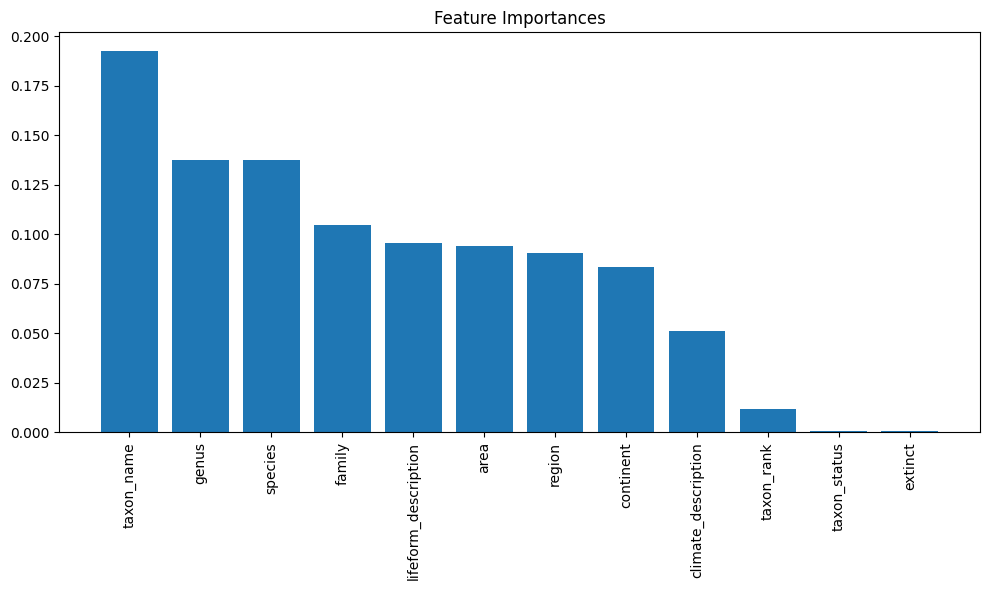

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rfc_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [13]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Set Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_xgb))


XGBoost Validation Set Results:
Accuracy: 0.9287977401561277
Confusion Matrix:
 [[92663   722]
 [ 6739  4662]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     93385
           1       0.87      0.41      0.56     11401

    accuracy                           0.93    104786
   macro avg       0.90      0.70      0.76    104786
weighted avg       0.92      0.93      0.92    104786



In [14]:
# The rfc_model performed well compared to the others
# using the rfc_model on the test data with the adjusted threshold
y_test_probs = rfc_model.predict_proba(X_test)[:, 1]
y_test_adjusted = (y_test_probs >= threshold).astype(int)

print("Adjusted Test Set Results:")
print("Accuracy:", accuracy_score(y_test, y_test_adjusted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_adjusted))
print("Classification Report:\n", classification_report(y_test, y_test_adjusted))

Adjusted Test Set Results:
Accuracy: 0.9570652848158646
Confusion Matrix:
 [[91263  2109]
 [ 2390  9025]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     93372
           1       0.81      0.79      0.80     11415

    accuracy                           0.96    104787
   macro avg       0.89      0.88      0.89    104787
weighted avg       0.96      0.96      0.96    104787



In [15]:
import joblib

joblib.dump(rfc_model, 'rfc_model.joblib')

['rfc_model.joblib']